In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("C:/Users/TANNERU/Downloads/Dataset for coding/Google_Stock_Price_Train.csv")

In [3]:
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [25]:
training = df.iloc[:, 1:2].values #open column

In [26]:
training

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [34]:
type(training)
print(training.shape)

(1258, 1)


# Feature scaling

In [35]:
#It is recommended to take Normalization rather than standardization, particularly when working on RNN with a Sigmoid function in the output layer.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(training)

In [36]:
training_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

# Creating a data structure with 60 timesteps and 1 output

In [37]:
Xtrain = []
Ytrain = []

In [41]:
#A special data structure is needed to cover 60-time stamps, 
#based on which RNN will predict the 61st price. Here the number of past timestamps is set to 60 based on experimentation.
for i in range(60,len(training_scaled)):
    Xtrain.append(training_scaled[i-60:i,0]) #0:60-->1:61-->2:62-->3:63-->4-64 
    Ytrain.append(training_scaled[i,0])
    

In [42]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [44]:
#Each row in Xtrain with 60 prices is used to predict the corresponding next-day stock price in y_train.
#1st row = 0-60 values,2nd row = 1-61 values,3rd row = 2-62,...........................  
print(Xtrain)
print(Xtrain.shape)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]
(1198, 60)


In [45]:
#Open price for prediction[60 to all values ]
print(Ytrain)
print(Ytrain.shape)

[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]
(1198,)


In [46]:
training_scaled[60:]

array([[0.08627874],
       [0.08471612],
       [0.07454052],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [47]:
Xtrain = np.reshape(Xtrain,newshape=(Xtrain.shape[0],Xtrain.shape[1],1))

In [48]:
#1198 rows,60 columns,1 dimension(indicator)
Xtrain.shape

(1198, 60, 1)

# Model building

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [114]:
# Initialising the RNN
#Fundamentally, we are building a NN regressor for continuous value prediction using LSTM.
regressor = Sequential()

#adding first LSTM and dropout to avoid overfitting
# return_sequences = True--> as we need to add another LSTM layer after the current one
#input_shape corresponds to the number of time stamps and the number of indicators.
#dropout to avoid overfitting
regressor.add(LSTM(50,activation = 'relu',return_sequences = True,input_shape = (Xtrain.shape[1],1)))
regressor.add(Dropout(0.3))

#add 2nd lstm layer
regressor.add(LSTM(50,activation = 'relu',return_sequences = True))
regressor.add(Dropout(0.3))

#add 3rd lstm layer
regressor.add(LSTM(50,activation = 'relu',return_sequences = True))
regressor.add(Dropout(0.3))

#add 4th lstm layer
#return_sequences is False as we will not add more LSTM layers.
regressor.add(LSTM(50,activation = 'relu',return_sequences = False))
regressor.add(Dropout(0.3))

In [115]:
# Adding the output layer
#We have created an LSTM based RNN model
regressor.add(Dense(1))

# Compliling

In [116]:
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [117]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)               

# Model fitting

In [118]:
#Now, let’s fit our RNN.
regressor.fit(Xtrain,Ytrain,epochs = 20,batch_size = 32)

Epoch 1/20
1198/1198 [==============================] - 12s 10ms/step - loss: 0.1207
Epoch 2/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0217
Epoch 3/20
1198/1198 [==============================] - 7s 5ms/step - loss: 0.0152
Epoch 4/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0132
Epoch 5/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0118
Epoch 6/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0109
Epoch 7/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0101
Epoch 8/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0101
Epoch 9/20
1198/1198 [==============================] - 7s 5ms/step - loss: 0.0090
Epoch 10/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0094
Epoch 11/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0085
Epoch 12/20
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0083

# Model prediction

In [119]:
testing_data = pd.read_csv("C:/Users/TANNERU/Downloads/Dataset for coding/Google_Stock_Price_Test.csv")

In [120]:
testing_data

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [121]:
real_stock_price = testing_data.iloc[:,1:2].values

In [122]:
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [123]:
df['Open'][-60:]#last 60 prices for open 

1198    779.00
1199    779.66
1200    777.71
1201    786.66
1202    783.76
1203    781.22
1204    781.65
1205    779.80
1206    787.85
1207    798.24
1208    803.30
1209    795.00
1210    804.90
1211    816.68
1212    806.34
1213    801.00
1214    808.35
1215    795.47
1216    782.89
1217    778.20
1218    767.25
1219    750.66
1220    774.50
1221    783.40
1222    779.94
1223    791.17
1224    756.54
1225    755.60
1226    746.97
1227    755.20
1228    766.92
1229    771.37
1230    762.61
1231    772.63
1232    767.73
1233    764.26
1234    760.00
1235    771.53
1236    770.07
1237    757.44
1238    744.59
1239    757.71
1240    764.73
1241    761.00
1242    772.48
1243    780.00
1244    785.04
1245    793.90
1246    797.40
1247    797.34
1248    800.40
1249    790.22
1250    796.76
1251    795.84
1252    792.36
1253    790.90
1254    790.68
1255    793.70
1256    783.33
1257    782.75
Name: Open, dtype: float64

In [124]:
"""First, we need to concatenate the train and test datasets for prediction,
because we use the previous 60 days’ 
stock prices to predict the next-day price.
In another word, we need the 60 days’ price before the 1st date in the test dataset.
"""
final = pd.concat((df['Open'][-60:],testing_data['Open']),axis = 0)

In [125]:
final

1198    779.00
1199    779.66
1200    777.71
1201    786.66
1202    783.76
         ...  
15      829.62
16      837.81
17      834.71
18      814.66
19      796.86
Name: Open, Length: 80, dtype: float64

In [126]:
final = np.array(final)
print(type(final))

<class 'numpy.ndarray'>


In [127]:
final

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [128]:
final = final.reshape(-1,1)
print(final.shape)

(80, 1)


In [129]:
final = sc.transform(final)

In [130]:
final

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [131]:
Xtest = []
for i in range(60,len(final)):
    Xtest.append(final[i-60:i,0])

In [132]:
Xtest

[array([0.9299055 , 0.93113327, 0.92750577, 0.94415507, 0.93876032,
        0.93403527, 0.93483518, 0.9313937 , 0.94636878, 0.96569685,
        0.97510976, 0.95966962, 0.97808617, 1.        , 0.98076494,
        0.97083116, 0.98450406, 0.96054394, 0.9371419 , 0.92841729,
        0.90804747, 0.8771858 , 0.92153434, 0.93809063, 0.93165414,
        0.95254483, 0.88812412, 0.88637547, 0.87032145, 0.88563137,
        0.90743359, 0.91571173, 0.89941588, 0.91805566, 0.9089404 ,
        0.9024853 , 0.89456061, 0.91600938, 0.9132934 , 0.88979835,
        0.86589404, 0.89030062, 0.90335962, 0.89642086, 0.91777662,
        0.93176576, 0.94114145, 0.95762334, 0.96413424, 0.96402262,
        0.96971501, 0.95077759, 0.96294367, 0.96123223, 0.95475854,
        0.95204256, 0.95163331, 0.95725128, 0.93796041, 0.93688146]),
 array([0.93113327, 0.92750577, 0.94415507, 0.93876032, 0.93403527,
        0.93483518, 0.9313937 , 0.94636878, 0.96569685, 0.97510976,
        0.95966962, 0.97808617, 1.        , 0.

In [133]:
Xtest = np.array(Xtest)
print(Xtest.shape)

(20, 60)


In [134]:
#make numpy array as 3D , adding num of indicator
Xtest = np.reshape(Xtest,newshape = (Xtest.shape[0],Xtest.shape[1],1))
print(Xtest.shape)

(20, 60, 1)


In [135]:
#prediction
predicted_stock_prices = regressor.predict(Xtest)

In [136]:
predicted_stock_prices

array([[0.8775413 ],
       [0.8790604 ],
       [0.8802689 ],
       [0.8811935 ],
       [0.8819114 ],
       [0.8825415 ],
       [0.88319266],
       [0.8839337 ],
       [0.8848083 ],
       [0.88583356],
       [0.88700235],
       [0.8882876 ],
       [0.8896512 ],
       [0.8910583 ],
       [0.8924786 ],
       [0.89393973],
       [0.895497  ],
       [0.8972219 ],
       [0.8991491 ],
       [0.90120745]], dtype=float32)

In [137]:
predicted_stock_prices.shape

(20, 1)

In [138]:
#transforming to orignal price values
predicted_stock_prices = sc.inverse_transform(predicted_stock_prices)

In [139]:
predicted_stock_prices

array([[750.8511 ],
       [751.66766],
       [752.3173 ],
       [752.8144 ],
       [753.20026],
       [753.539  ],
       [753.88904],
       [754.2874 ],
       [754.7575 ],
       [755.3087 ],
       [755.93695],
       [756.62787],
       [757.36084],
       [758.1173 ],
       [758.88074],
       [759.6662 ],
       [760.50336],
       [761.4306 ],
       [762.4666 ],
       [763.57306]], dtype=float32)

# Data Visualization

In [140]:
import matplotlib.pyplot as plt

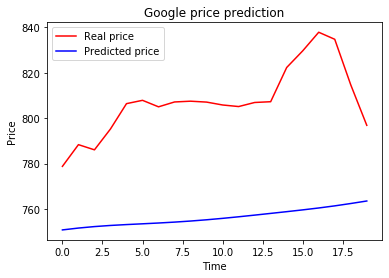

In [141]:
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_prices, color = 'blue', label = 'Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()